In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import psycopg2
import calendar

In [2]:
conn = psycopg2.connect(
    host='hp-dev-db-12sep.cgitnjqny0tw.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='hp_read_user',
    password='hp_@_2023_321',
    database='postgres'
)

In [3]:
query1 = """select created::date, id, order_status, ordered_via, user_id, order_amount from sales_userorderdata;"""

query2 = """select created::date, order_id, product_name, quantity from sales_userorderproductsizedata"""

In [4]:
e=pd.read_sql(query1,conn)
e.columns = ["created", "order_id", "order_status", "order_channel", "user_id", "order_amount"]
e['created'] = pd.to_datetime(e['created'])
#OrderCount, ASP, AOV, GMV, Acquistion Ratio, Repeat Rate

f = pd.read_sql(query2,conn)
f.columns = ["created", "order_id", "product_name", "quantity"]
f['created'] = pd.to_datetime(f['created'])
OrderSKUMap=f.groupby('order_id').agg(
        SKUs=pd.NamedAgg(column='product_name', aggfunc= 'nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    ).reset_index()

# Set Data Columns
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters


x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OrderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),

    ).reset_index()


e2=e.merge(x1[['user_id','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2=e2.merge(OrderSKUMap, left_on='order_id', right_on='order_id', how='left')

e2['TrxnRank'] = e2.groupby('user_id')['OrderDate'].rank(method='first')
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']


#fetch metrices

e2['New']=0
e2.loc[e2['TrxnRank']==1,'New']=1
e2['Repeat']=0
e2.loc[e2['TrxnRank']>1,'Repeat']=1

e2 = e2[e2["New"] == 1]

# e2['order_id']=e2['order_id_x']
y2=e2.groupby('OrderDate').agg(
        OrderCounts=pd.NamedAgg(column='order_id', aggfunc= 'count'),
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),

    ).reset_index()

cancelled_orders = e2[e2['order_status'] == 'Cancelled'].groupby('OrderDate').agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

delivered_orders = e2[e2['order_status'] == 'Delivered'].groupby('OrderDate').agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

y3=e2.groupby(['OrderDate', "user_id"]).agg(
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),
).reset_index()
y3['UserRank']=y3.groupby('user_id')['OrderDate'].rank(method='first')
y3 = y3.groupby('OrderDate').agg(
    NewUserCount=pd.NamedAgg(column='UserRank', aggfunc=lambda x: (x == 1.0).sum())
)

y2 = y2.merge(cancelled_orders, on='OrderDate', how='left')
y2 = y2.merge(delivered_orders, on='OrderDate', how='left')
y2['CancellationCount'].fillna(0, inplace=True)
y2['DeliveryCount'].fillna(0, inplace=True)

y2=y2.merge(y3, left_on='OrderDate', right_on='OrderDate')

ordered_via_values = e2['order_channel'].unique()
for ordered_via in ordered_via_values:
    y2[f'Channel_{ordered_via}'] = 0
for ordered_via in ordered_via_values:
    orders_by_channel = e2[e2['order_channel'] == ordered_via].groupby('OrderDate').size()
    y2[f'Channel_{ordered_via}'] = y2['OrderDate'].map(orders_by_channel).fillna(0)

# y2['NewOrderRatio']=y2['NewTrxns']/y2['OrderCounts']
# y2['RepeatOrderRatio']=y2['RepearTrxns']/y2['OrderCounts']
y2['UnitsperOrder']=y2['Quantity']/y2['OrderCounts']
y2['SKUsperOrder']=y2['SKUCount']/y2['OrderCounts']
y2['ASP']=y2['TotalOrderValue']/y2['Quantity']
y2['CancellationRate']=y2['CancellationCount']/y2['OrderCounts']
# y2["RepeatUserCount"] = y2["ActiveUsersCounts"] - y2["NewUserCount"]

metrics=['OrderCounts','TotalOrderValue','AOV','ASP','SKUsperOrder','UnitsperOrder','CancellationCount', 'CancellationRate']
for ordered_via in ordered_via_values:
    metric = f'Channel_{ordered_via}'
    metrics.append(metric)
y2.columns = ["Order_Date", "Order_Counts", "Total_Order_Value", "AOV", "Total_Quantity", "Products_Count", "Cancelled_Order_Counts", "Delivered_Orders_Counts", "New_User_Counts", "Channel_Android App", "Channel_Whatsapp", "Channel_Web App", "Channel_IOS App", "No_Units_per_Order", "No_Products_per_Order", "ASP", "Calcellation_Rate_(in %)"]

<ipython-input-4-6710b75823b8>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(query1,conn)
<ipython-input-4-6710b75823b8>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  f = pd.read_sql(query2,conn)


In [5]:
y2.head()

,Order_Date,Order_Counts,Total_Order_Value,AOV,Total_Quantity,Products_Count,Cancelled_Order_Counts,Delivered_Orders_Counts,New_User_Counts,Channel_Android App,Channel_Whatsapp,Channel_Web App,Channel_IOS App,No_Units_per_Order,No_Products_per_Order,ASP,Calcellation_Rate_(in %)
0,2019-04-01,143,138427.00,968.020979,1836.0,474.0,6.0,137.0,143,143.0,0.0,0.0,0.0,12.839161,3.314685,75.395969,0.041958
1,2019-04-02,185,250601.16,1354.600865,2479.0,801.0,8.0,177.0,185,185.0,0.0,0.0,0.0,13.400000,4.329730,101.089617,0.043243
2,2019-04-03,215,247525.98,1151.283628,2395.0,786.0,8.0,207.0,215,215.0,0.0,0.0,0.0,11.139535,3.655814,103.351140,0.037209
3,2019-04-04,177,230733.17,1303.577232,2193.0,683.0,2.0,175.0,177,177.0,0.0,0.0,0.0,12.389831,3.858757,105.213484,0.011299
4,2019-04-05,155,222764.22,1437.188516,2390.0,666.0,4.0,151.0,155,155.0,0.0,0.0,0.0,15.419355,4.296774,93.206787,0.025806


In [6]:
x = y2.copy()

In [7]:
e=pd.read_sql(query1,conn)
e.columns = ["created", "order_id", "order_status", "order_channel", "user_id", "order_amount"]
e['created'] = pd.to_datetime(e['created'])
#OrderCount, ASP, AOV, GMV, Acquistion Ratio, Repeat Rate

f = pd.read_sql(query2,conn)
f.columns = ["created", "order_id", "product_name", "quantity"]
f['created'] = pd.to_datetime(f['created'])
OrderSKUMap=f.groupby('order_id').agg(
        SKUs=pd.NamedAgg(column='product_name', aggfunc= 'nunique'),
        Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
    ).reset_index()

# Set Data Columns
e['OrderDate']=e['created'].dt.date
e['OrderDate']=pd.to_datetime(e['OrderDate'])
#Delta Columns
e['DeltaDaysinOrders']=(e.groupby('user_id').OrderDate.shift() - e.OrderDate).dt.days.abs()
e['DeltaOrderValues']=(e.groupby('user_id').order_amount.shift() - e.order_amount)
#Analysis Parameters


x1=e.groupby('user_id').agg(
        LastDate=pd.NamedAgg(column='OrderDate', aggfunc= 'max'),
        FirstDate=pd.NamedAgg(column='OrderDate', aggfunc='min'),

    ).reset_index()


e2=e.merge(x1[['user_id','LastDate','FirstDate']], left_on='user_id', right_on='user_id')
e2=e2.merge(OrderSKUMap, left_on='order_id', right_on='order_id', how='left')

e2['TrxnRank'] = e2.groupby('user_id')['OrderDate'].rank(method='first')
# e2=e2[e2['OrderDate']>='2022-01-01']
# e2=e2[e2['OrderDate']<='2022-12-31']


#fetch metrices

e2['New']=0
e2.loc[e2['TrxnRank']==1,'New']=1
e2['Repeat']=0
e2.loc[e2['TrxnRank']>1,'Repeat']=1
#e2['order_id']=e2['order_id_x']
y2=e2.groupby('OrderDate').agg(
        OrderCounts=pd.NamedAgg(column='order_id', aggfunc= 'count'),
        ActiveUsersCounts=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
        AOV=pd.NamedAgg(column='order_amount', aggfunc='mean'),
        NewTrxns=pd.NamedAgg(column='New', aggfunc='sum'),
    RepearTrxns=pd.NamedAgg(column='Repeat', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),

    ).reset_index()

cancelled_orders = e[e['order_status'] == 'Cancelled'].groupby('OrderDate').agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

delivered_orders = e[e['order_status'] == 'Delivered'].groupby('OrderDate').agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).reset_index()

y3=e2.groupby(['OrderDate', "user_id"]).agg(
        TotalOrderValue=pd.NamedAgg(column='order_amount', aggfunc='sum'),
    Quantity=pd.NamedAgg(column='Quantity', aggfunc='sum'),
SKUCount=pd.NamedAgg(column='SKUs', aggfunc='sum'),
).reset_index()
y3['UserRank']=y3.groupby('user_id')['OrderDate'].rank(method='first')
y3 = y3.groupby('OrderDate').agg(
    NewUserCount=pd.NamedAgg(column='UserRank', aggfunc=lambda x: (x == 1.0).sum())
)

y2 = y2.merge(cancelled_orders, on='OrderDate', how='left')
y2 = y2.merge(delivered_orders, on='OrderDate', how='left')
y2['CancellationCount'].fillna(0, inplace=True)
y2['DeliveryCount'].fillna(0, inplace=True)

y2=y2.merge(y3, left_on='OrderDate', right_on='OrderDate')

ordered_via_values = e['order_channel'].unique()
for ordered_via in ordered_via_values:
    y2[f'Channel_{ordered_via}'] = 0
for ordered_via in ordered_via_values:
    orders_by_channel = e[e['order_channel'] == ordered_via].groupby('OrderDate').size()
    y2[f'Channel_{ordered_via}'] = y2['OrderDate'].map(orders_by_channel).fillna(0)

y2['NewOrderRatio']=y2['NewTrxns']/y2['OrderCounts']
y2['RepeatOrderRatio']=y2['RepearTrxns']/y2['OrderCounts']
y2['UnitsperOrder']=y2['Quantity']/y2['OrderCounts']
y2['SKUsperOrder']=y2['SKUCount']/y2['OrderCounts']
y2['ASP']=y2['TotalOrderValue']/y2['Quantity']
y2['CancellationRate (in %)']=y2['CancellationCount']*100/y2['OrderCounts']
y2["RepeatUserCount"] = y2["ActiveUsersCounts"] - y2["NewUserCount"]

metrics=['OrderCounts','ActiveUsersCounts','NewUserCount','RepeatUserCount','TotalOrderValue','AOV','ASP','NewOrderRatio','SKUsperOrder','UnitsperOrder','DeliveryCount','CancellationCount', 'CancellationRate']
for ordered_via in ordered_via_values:
    metric = f'Channel_{ordered_via}'
    metrics.append(metric)

print(metrics)

<ipython-input-7-4b69f515cf8e>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  e=pd.read_sql(query1,conn)
<ipython-input-7-4b69f515cf8e>:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  f = pd.read_sql(query2,conn)


['OrderCounts', 'ActiveUsersCounts', 'NewUserCount', 'RepeatUserCount', 'TotalOrderValue', 'AOV', 'ASP', 'NewOrderRatio', 'SKUsperOrder', 'UnitsperOrder', 'DeliveryCount', 'CancellationCount', 'CancellationRate', 'Channel_Whatsapp', 'Channel_Web App', 'Channel_Android App', 'Channel_IOS App']


In [8]:
#y is overall data
y2.head(1)

,OrderDate,OrderCounts,ActiveUsersCounts,TotalOrderValue,AOV,NewTrxns,RepearTrxns,Quantity,SKUCount,CancellationCount,...,Channel_Web App,Channel_Android App,Channel_IOS App,NewOrderRatio,RepeatOrderRatio,UnitsperOrder,SKUsperOrder,ASP,CancellationRate (in %),RepeatUserCount
0,2019-04-01,151,143,140902.42,933.128609,143,8,1851.0,489.0,6.0,...,0.0,151.0,0.0,0.94702,0.05298,12.258278,3.238411,76.122323,3.97351,0


In [9]:
y2.columns

Index(['OrderDate', 'OrderCounts', 'ActiveUsersCounts', 'TotalOrderValue',
       'AOV', 'NewTrxns', 'RepearTrxns', 'Quantity', 'SKUCount',
       'CancellationCount', 'DeliveryCount', 'NewUserCount',
       'Channel_Whatsapp', 'Channel_Web App', 'Channel_Android App',
       'Channel_IOS App', 'NewOrderRatio', 'RepeatOrderRatio', 'UnitsperOrder',
       'SKUsperOrder', 'ASP', 'CancellationRate (in %)', 'RepeatUserCount'],
      dtype='object')

In [10]:
#x is just for new_customers
x.head(1)

,Order_Date,Order_Counts,Total_Order_Value,AOV,Total_Quantity,Products_Count,Cancelled_Order_Counts,Delivered_Orders_Counts,New_User_Counts,Channel_Android App,Channel_Whatsapp,Channel_Web App,Channel_IOS App,No_Units_per_Order,No_Products_per_Order,ASP,Calcellation_Rate_(in %)
0,2019-04-01,143,138427.0,968.020979,1836.0,474.0,6.0,137.0,143,143.0,0.0,0.0,0.0,12.839161,3.314685,75.395969,0.041958


In [11]:
y2.columns = ['Overall_' + col for col in y2.columns]

In [12]:
y2.head(1)

,Overall_OrderDate,Overall_OrderCounts,Overall_ActiveUsersCounts,Overall_TotalOrderValue,Overall_AOV,Overall_NewTrxns,Overall_RepearTrxns,Overall_Quantity,Overall_SKUCount,Overall_CancellationCount,...,Overall_Channel_Web App,Overall_Channel_Android App,Overall_Channel_IOS App,Overall_NewOrderRatio,Overall_RepeatOrderRatio,Overall_UnitsperOrder,Overall_SKUsperOrder,Overall_ASP,Overall_CancellationRate (in %),Overall_RepeatUserCount
0,2019-04-01,151,143,140902.42,933.128609,143,8,1851.0,489.0,6.0,...,0.0,151.0,0.0,0.94702,0.05298,12.258278,3.238411,76.122323,3.97351,0


In [13]:
y2['Week'] = y2['Overall_OrderDate'].dt.strftime('%Y-w%U')
x['Week'] = x['Order_Date'].dt.strftime('%Y-w%U')

In [14]:
y2_new= y2.groupby('Week').agg({
    'Overall_OrderCounts': 'sum',
    'Overall_ActiveUsersCounts': 'sum',
    'Overall_TotalOrderValue': 'sum',
    'Overall_AOV': 'mean',
    'Overall_NewTrxns': 'sum',
    'Overall_RepearTrxns': 'sum',
    'Overall_Quantity': 'sum',
    'Overall_SKUCount': 'sum',
    'Overall_CancellationCount': 'sum',
    'Overall_DeliveryCount': 'sum',
    'Overall_NewUserCount': 'sum',
    'Overall_Channel_Whatsapp': 'sum',
    'Overall_Channel_Android App': 'sum',
    'Overall_Channel_IOS App': 'sum',
    'Overall_Channel_Web App': 'sum',
    'Overall_NewOrderRatio': 'mean',
    'Overall_RepeatOrderRatio': 'mean',
    'Overall_UnitsperOrder': 'mean',
    'Overall_SKUsperOrder': 'mean',
    'Overall_ASP': 'mean',
    'Overall_CancellationRate (in %)': 'mean',
    'Overall_RepeatUserCount': 'sum'
})

In [16]:
x.drop('New_User_Counts', axis=1, inplace=True)

In [17]:
x.columns = ['New_' + col for col in x.columns]

In [18]:
x.columns

Index(['New_Order_Date', 'New_Order_Counts', 'New_Total_Order_Value',
       'New_AOV', 'New_Total_Quantity', 'New_Products_Count',
       'New_Cancelled_Order_Counts', 'New_Delivered_Orders_Counts',
       'New_Channel_Android App', 'New_Channel_Whatsapp',
       'New_Channel_Web App', 'New_Channel_IOS App', 'New_No_Units_per_Order',
       'New_No_Products_per_Order', 'New_ASP', 'New_Calcellation_Rate_(in %)',
       'New_Week'],
      dtype='object')

In [19]:
x = x.rename(columns={
    'New_Order_Date': 'Order_Date',
    'New_Week':'Week'
})

In [20]:
x.columns

Index(['Order_Date', 'New_Order_Counts', 'New_Total_Order_Value', 'New_AOV',
       'New_Total_Quantity', 'New_Products_Count',
       'New_Cancelled_Order_Counts', 'New_Delivered_Orders_Counts',
       'New_Channel_Android App', 'New_Channel_Whatsapp',
       'New_Channel_Web App', 'New_Channel_IOS App', 'New_No_Units_per_Order',
       'New_No_Products_per_Order', 'New_ASP', 'New_Calcellation_Rate_(in %)',
       'Week'],
      dtype='object')

In [21]:
x_new = x.groupby('Week').agg({
    'New_Order_Counts': 'sum',
    'New_Total_Order_Value': 'sum',
    'New_AOV': 'mean',
    'New_Total_Quantity': 'sum',
    'New_Products_Count': 'sum',
    'New_Cancelled_Order_Counts': 'sum',
    'New_Delivered_Orders_Counts': 'sum',
    'New_Channel_Android App': 'sum',
    'New_Channel_Whatsapp': 'sum',
    'New_Channel_Web App': 'sum',
    'New_Channel_IOS App': 'sum',
    'New_No_Units_per_Order': 'mean',
    'New_No_Products_per_Order': 'mean',
    'New_ASP': 'mean',
    'New_Calcellation_Rate_(in %)': 'mean'
})

In [22]:
x_new.head(1)

,New_Order_Counts,New_Total_Order_Value,New_AOV,New_Total_Quantity,New_Products_Count,New_Cancelled_Order_Counts,New_Delivered_Orders_Counts,New_Channel_Android App,New_Channel_Whatsapp,New_Channel_Web App,New_Channel_IOS App,New_No_Units_per_Order,New_No_Products_per_Order,New_ASP,New_Calcellation_Rate_(in %)
Week,,,,,,,,,,,,,,,
2019-w13,1007,1219134.97,1198.762678,12867.0,3922.0,32.0,975.0,1007.0,0.0,0.0,0.0,12.852021,3.889091,93.377801,0.031637


In [23]:
y2_new.head(1)

,Overall_OrderCounts,Overall_ActiveUsersCounts,Overall_TotalOrderValue,Overall_AOV,Overall_NewTrxns,Overall_RepearTrxns,Overall_Quantity,Overall_SKUCount,Overall_CancellationCount,Overall_DeliveryCount,...,Overall_Channel_Android App,Overall_Channel_IOS App,Overall_Channel_Web App,Overall_NewOrderRatio,Overall_RepeatOrderRatio,Overall_UnitsperOrder,Overall_SKUsperOrder,Overall_ASP,Overall_CancellationRate (in %),Overall_RepeatUserCount
Week,,,,,,,,,,,,,,,,,,,,,
2019-w13,1207,1153,1403636.66,1150.262676,1007,200,16503.0,4481.0,41.0,1166.0,...,1207.0,0.0,0.0,0.836966,0.163034,13.736544,3.701208,87.700745,3.371426,146


In [24]:
temp = x_new[['New_Total_Order_Value','New_AOV']]
temp.head(1)

,New_Total_Order_Value,New_AOV
Week,,
2019-w13,1219134.97,1198.762678


In [25]:
temp_result = pd.merge(y2_new,temp,on='Week')

In [26]:
temp_result.head()

,Overall_OrderCounts,Overall_ActiveUsersCounts,Overall_TotalOrderValue,Overall_AOV,Overall_NewTrxns,Overall_RepearTrxns,Overall_Quantity,Overall_SKUCount,Overall_CancellationCount,Overall_DeliveryCount,...,Overall_Channel_Web App,Overall_NewOrderRatio,Overall_RepeatOrderRatio,Overall_UnitsperOrder,Overall_SKUsperOrder,Overall_ASP,Overall_CancellationRate (in %),Overall_RepeatUserCount,New_Total_Order_Value,New_AOV
Week,,,,,,,,,,,,,,,,,,,,,
2019-w13,1207,1153,1403636.66,1150.262676,1007,200,16503.0,4481.0,41.0,1166.0,...,0.0,0.836966,0.163034,13.736544,3.701208,87.700745,3.371426,146,1219134.97,1198.762678
2019-w14,1288,1230,1634931.52,1186.618347,761,527,27717.0,4369.0,51.0,1237.0,...,0.0,0.580746,0.419254,19.034518,3.211544,86.746480,4.073215,469,1261656.82,1509.154171
2019-w15,1202,1134,1278775.04,1003.254731,531,671,12775.0,4079.0,48.0,1154.0,...,0.0,0.459641,0.540359,10.378057,3.250416,98.961126,4.224534,603,710669.32,1228.968606
2019-w16,1276,1211,1268171.19,1023.745296,452,824,12469.0,4242.0,45.0,1231.0,...,0.0,0.343018,0.656982,9.447054,3.301489,110.702887,3.022950,759,529352.94,1172.380454
2019-w17,1424,1364,1462937.40,1008.270927,364,1060,15592.0,5039.0,60.0,1364.0,...,0.0,0.254514,0.745486,10.409866,3.431888,99.304169,4.999972,1000,385961.74,1072.873007


In [27]:
result = temp_result[['Overall_OrderCounts','Overall_ActiveUsersCounts','Overall_TotalOrderValue','Overall_AOV','Overall_NewTrxns','Overall_RepearTrxns','New_AOV','New_Total_Order_Value']]

In [28]:
result.head(1)

,Overall_OrderCounts,Overall_ActiveUsersCounts,Overall_TotalOrderValue,Overall_AOV,Overall_NewTrxns,Overall_RepearTrxns,New_AOV,New_Total_Order_Value
Week,,,,,,,,
2019-w13,1207,1153,1403636.66,1150.262676,1007,200,1198.762678,1219134.97


In [29]:
result = result.rename(columns={
    'Overall_NewTrxns': 'New_ActiveusersCounts',
    'New_Total_Order_Value': 'New_TotalOrderValue',
})

In [30]:
result.head(1)

,Overall_OrderCounts,Overall_ActiveUsersCounts,Overall_TotalOrderValue,Overall_AOV,New_ActiveusersCounts,Overall_RepearTrxns,New_AOV,New_TotalOrderValue
Week,,,,,,,,
2019-w13,1207,1153,1403636.66,1150.262676,1007,200,1198.762678,1219134.97


In [31]:
result['NewUserRatio'] = result['New_ActiveusersCounts'] / result['Overall_OrderCounts']
result['RepeatUserRatio'] = result['Overall_RepearTrxns']/ result['Overall_OrderCounts']
result = result.rename(columns={
    'Overall_RepearTrxns':'Repeat_Transactions'
})

In [33]:
result.head(1)
column_order = ['Overall_OrderCounts','Repeat_Transactions','New_ActiveusersCounts','Overall_ActiveUsersCounts','New_TotalOrderValue','Overall_TotalOrderValue','Overall_AOV','New_AOV','NewUserRatio','RepeatUserRatio']
result = result[column_order]

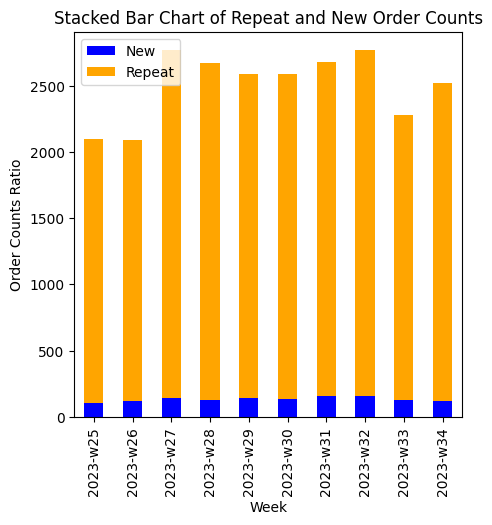

In [41]:
def comp1(result, x):
  result = result[:-6]
  result = result.tail(10)
  if x=='User Ratio':
    ax = result['NewUserRatio'].plot(kind='line', figsize=(5, 5), color=['orange'])
    plt.title('User Ratio')
    plt.xlabel('Week')
    plt.ylabel('New User Ratio')
    plt.legend('New Order Ratio')
    plt.show()

  if x=='Order Counts':
    ax = result[['New_ActiveusersCounts', 'Repeat_Transactions']].plot(kind='bar', stacked=True, figsize=(5, 5), color=['blue', 'orange'])
    plt.title('Stacked Bar Chart of Repeat and New Order Counts')
    plt.xlabel('Week')
    plt.ylabel('Order Counts Ratio')
    plt.legend(['New', 'Repeat'])
    plt.show()

comp1(result, 'Order Counts')

Performing Delta Analytics

*   x1 - The column which the user wants to review
*   x2 - Highest or the Lowest



In [37]:
def comp2_part1(main, x1, x2):
  main = main[:-6]
  main_delta = main.diff(axis=0).dropna()
  main_delta.sort_values(by=x1, ascending=False, inplace=True)
  if x2 == 'Highest':
    highest_list = main_delta.head(1).index.tolist()
    highest = main[main.index.isin(highest_list)]

    x = highest.index.values[0]
    y = main.index.get_loc(x)
    main.iloc[y-1:y]

    new_highest = pd.concat([main.iloc[y-1:y],highest])
    return new_highest
  if x2 == 'Lowest':
    lowest_list = main_delta.tail(1).index.tolist()
    lowest = main[main.index.isin(lowest_list)]

    x = lowest.index.values[0]
    y = main.index.get_loc(x)
    main.iloc[y-1:y]

    new_lowest = pd.concat([main.iloc[y-1:y],lowest])
    return new_lowest

In [38]:
comp2_part1(result, 'New_TotalOrderValue', 'Highest')

,Overall_OrderCounts,Repeat_Transactions,New_ActiveusersCounts,Overall_ActiveUsersCounts,New_TotalOrderValue,Overall_TotalOrderValue,Overall_AOV,New_AOV,NewUserRatio,RepeatUserRatio
Week,,,,,,,,,,
2021-w14,4651,4415,236,4187,205600.0,4416485.0,943.740060,889.197953,0.050742,0.949258
2021-w15,4772,4323,449,4080,648431.0,5107810.0,1057.922416,1407.136762,0.094091,0.905909


Week vs last 6 week


*   Best
*   Average
*   Worst






In [39]:
def comp2_part2(result, x):
  result = result[:-6]
  if x=='Week vs last 6 weeks Avg':
    last_6_weeks_avg = result.iloc[-7:-1].mean()
    last_6_weeks_avg = pd.DataFrame(last_6_weeks_avg, columns=['Average']).transpose()
    last_6_weeks_avg.index = ['Last 6 Week Average']
    last_6_weeks_avg.index.name='week'
    last_week = result.iloc[-1:]
    week_vs_last_6_weeks_avg = pd.concat([last_6_weeks_avg,last_week])
    week_vs_last_6_weeks_avg.loc['delta_week_vs_last_6_weeks_avg'] = week_vs_last_6_weeks_avg.iloc[1] - week_vs_last_6_weeks_avg.iloc[0]
    week_vs_last_6_weeks_avg.loc['delta_week_vs_last_6_weeks_avg_in_percentage'] = ((week_vs_last_6_weeks_avg.iloc[1] - week_vs_last_6_weeks_avg.iloc[0])/week_vs_last_6_weeks_avg.iloc[1])*100
    return week_vs_last_6_weeks_avg.round(2)
  if x =='Week vs last 6 weeks Best':
    last_6_weeks_best = result.iloc[-7:-1].sort_values(by=result.columns[0],ascending=True).tail(1)
    last_6_weeks_best.index = [f'Last 6 Week Best- {last_6_weeks_best.index.values[0]}']
    last_week = result.iloc[-1:]
    week_vs_last_6_weeks_top = pd.concat([last_6_weeks_best,last_week])
    week_vs_last_6_weeks_top.loc['delta_week_vs_last_6_weeks_Best'] = week_vs_last_6_weeks_top.iloc[1] - week_vs_last_6_weeks_top.iloc[0]
    week_vs_last_6_weeks_top.loc['delta_week_vs_last_6_weeks_Best_in_percentage'] = ((week_vs_last_6_weeks_top.iloc[1] - week_vs_last_6_weeks_top.iloc[0])/week_vs_last_6_weeks_top.iloc[1])*100
    return week_vs_last_6_weeks_top.round(2)
  if x=='Week vs last 6 weeks Worst':
    last_6_weeks_bottom = result.iloc[-7:-1].sort_values(by=result.columns[0],ascending=True).head(1)
    last_6_weeks_bottom.index = [f'Last 6 Week Worst- {last_6_weeks_bottom.index.values[0]}']
    last_week = result.iloc[-1:]
    week_vs_last_6_weeks_bottom = pd.concat([last_6_weeks_bottom,last_week])
    week_vs_last_6_weeks_bottom.loc['delta_week_vs_last_6_weeks_Worst'] = week_vs_last_6_weeks_bottom.iloc[1] - week_vs_last_6_weeks_bottom.iloc[0]
    week_vs_last_6_weeks_bottom.loc['delta_week_vs_last_6_weeks_Worst_in_percentage'] = ((week_vs_last_6_weeks_bottom.iloc[1] - week_vs_last_6_weeks_bottom.iloc[0])/week_vs_last_6_weeks_bottom.iloc[1])*100
    return week_vs_last_6_weeks_bottom.round(2)

In [40]:
comp2_part2(result, 'Week vs last 6 weeks Best')

,Overall_OrderCounts,Repeat_Transactions,New_ActiveusersCounts,Overall_ActiveUsersCounts,New_TotalOrderValue,Overall_TotalOrderValue,Overall_AOV,New_AOV,NewUserRatio,RepeatUserRatio
Last 6 Week Best- 2023-w32,2767.00,2613.00,154.00,2419.00,236829.00,3061117.25,1114.53,1662.00,0.06,0.94
2023-w34,2516.00,2399.00,117.00,2217.00,154834.00,2726149.67,1080.43,1321.43,0.05,0.95
delta_week_vs_last_6_weeks_Best,-251.00,-214.00,-37.00,-202.00,-81995.00,-334967.58,-34.09,-340.56,-0.01,0.01
delta_week_vs_last_6_weeks_Best_in_percentage,-9.98,-8.92,-31.62,-9.11,-52.96,-12.29,-3.16,-25.77,-19.68,0.96
